<a href="https://colab.research.google.com/github/CinthiaDayanara/serie-de-tiempo/blob/main/ejemplo_cooperativas.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Montar Google Drive para acceder a archivos
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
import matplotlib.pyplot as plt

In [3]:
# Cargar datos desde Google Drive
ruta_archivo = '/content/drive/MyDrive/cooperativas.xlsx'  # Ajusta la ruta si es necesario
df = pd.read_excel(ruta_archivo)

In [4]:
# Mostrar información general del DataFrame
print("\nInformación del archivo:")
print(df.info())


Información del archivo:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 127 entries, 0 to 126
Data columns (total 2 columns):
 #   Column                                                         Non-Null Count  Dtype  
---  ------                                                         --------------  -----  
 0   Category                                                       127 non-null    object 
 1   Cooperativas S1 | Total Captaciones a plazo |  Tasa Nominal |  127 non-null    float64
dtypes: float64(1), object(1)
memory usage: 2.1+ KB
None


In [5]:
# Asegurarse de que los datos tengan un índice de tiempo
df['Category'] = pd.to_datetime(df['Category'])
df.set_index('Category', inplace=True)

In [6]:
# Asegurarse de que la frecuencia sea semanal
df = df.resample('W').mean()  # Promedio semanal (puedes cambiar esto según tus datos)


In [7]:
# Seleccionar solo la columna de interés (e.g., valores numéricos)
data = df['Cooperativas S1 | Total Captaciones a plazo |  Tasa Nominal |'].values.reshape(-1, 1)

In [8]:
# 2. Normalización de los datos
scaler = MinMaxScaler(feature_range=(0, 1))
data_normalizada = scaler.fit_transform(data)

In [9]:
# 3. Preparar datos para LSTM
def crear_secuencias(datos, pasos):
    X, y = [], []
    for i in range(len(datos) - pasos):
        X.append(datos[i:i+pasos])
        y.append(datos[i+pasos])
    return np.array(X), np.array(y)

pasos = 15  # Ventana de tiempo (15 semanas)
X, y = crear_secuencias(data_normalizada, pasos)

In [10]:
# Dividir en datos de entrenamiento y prueba
porcentaje_entrenamiento = 0.8
tamaño_entrenamiento = int(len(X) * porcentaje_entrenamiento)
X_train, X_test = X[:tamaño_entrenamiento], X[tamaño_entrenamiento:]
y_train, y_test = y[:tamaño_entrenamiento], y[tamaño_entrenamiento:]

In [11]:
# 4. Definir el modelo LSTM
modelo = Sequential([
    LSTM(50, activation='relu', input_shape=(X_train.shape[1], X_train.shape[2])),
    Dense(1)
])
modelo.compile(optimizer='adam', loss='mean_squared_error')

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [12]:
# 5. Entrenamiento del modelo
modelo.fit(X_train, y_train, epochs=50, batch_size=16, validation_data=(X_test, y_test))

Epoch 1/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 3s 68ms/step - loss: 0.1737 - val_loss: 0.5759
Epoch 2/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.1145 - val_loss: 0.4120
Epoch 3/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0853 - val_loss: 0.2613
Epoch 4/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0431 - val_loss: 0.1149
Epoch 5/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0183 - val_loss: 0.0104
Epoch 6/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0173 - val_loss: 0.0080
Epoch 7/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0128 - val_loss: 0.0236
Epoch 8/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0107 - val_loss: 0.0318
Epoch 9/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0114 - val_loss: 0.0235
Epoch 10/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0109 - val_loss: 0.0123
Epoch 11/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0103 - val_loss: 0.0093
Epoch 12/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0085 - val_loss: 0.0096
E

In [13]:
# Predicción de fechas futuras
predicciones_futuras = []
entrada = data_normalizada[-pasos:].reshape(1, pasos, 1)  # Última secuencia (3D)

num_fechas_a_predecir = 4  # Cambia al número de fechas que quieras predecir
for _ in range(num_fechas_a_predecir):
    prediccion = modelo.predict(entrada, verbose=0)  # Predicción del modelo
    predicciones_futuras.append(prediccion[0][0])  # Guardar la predicción

    # Actualizar la entrada con la predicción
    nueva_prediccion = np.array(prediccion[0][0]).reshape(1, 1, 1)  # Asegurar que la predicción sea 3D
    entrada = np.append(entrada[:, 1:, :], nueva_prediccion, axis=1)  # Actualizar la ventana de entrada

In [14]:
# Desnormalizar las predicciones
predicciones_futuras = scaler.inverse_transform(np.array(predicciones_futuras).reshape(-1, 1))

In [15]:
# Generar las fechas futuras
fechas_futuras = pd.date_range(start=df.index[-1], periods=num_fechas_a_predecir + 1, freq='W')[1:]

In [16]:
# Mostrar resultados
print("\nFechas futuras y predicciones:")
for fecha, valor in zip(fechas_futuras, predicciones_futuras):
    print(f"{fecha.date()}: {valor[0]:.2f}")



Fechas futuras y predicciones:
2024-06-16: 8.22
2024-06-23: 8.27
2024-06-30: 8.33
2024-07-07: 8.40


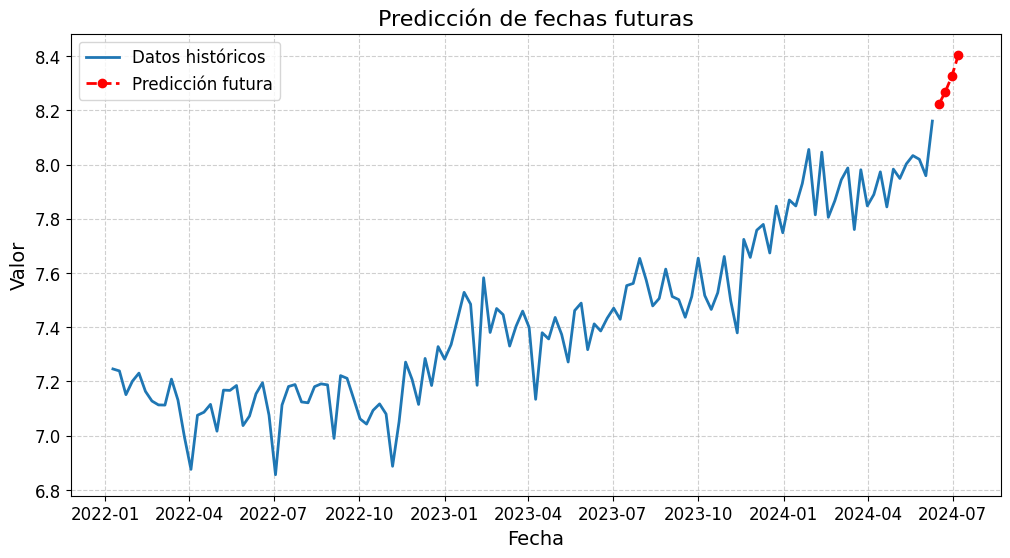

In [17]:
# Visualización con ajuste de tamaño
plt.figure(figsize=(12, 6))  # Cambia las dimensiones (ancho, alto) según prefieras
plt.plot(df.index, data, label='Datos históricos', linewidth=2)
plt.plot(fechas_futuras, predicciones_futuras, label='Predicción futura', marker='o', linestyle='--', color='red', linewidth=2)
plt.legend(fontsize=12)  # Ajusta el tamaño de la leyenda
plt.xlabel('Fecha', fontsize=14)
plt.ylabel('Valor', fontsize=14)
plt.title('Predicción de fechas futuras', fontsize=16)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.grid(True, linestyle='--', alpha=0.6)  # Añade una cuadrícula para mejor legibilidad
plt.show()

In [18]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

# Supongamos que 'valores_reales' son los datos reales de validación
# y 'predicciones' son las predicciones generadas por el modelo
valores_reales = data[-len(predicciones_futuras):]  # Ejemplo: últimos valores del conjunto de datos
predicciones = predicciones_futuras  # Las predicciones generadas por el modelo

# Cálculo de métricas
mae = mean_absolute_error(valores_reales, predicciones)
mse = mean_squared_error(valores_reales, predicciones)
rmse = np.sqrt(mse)

# Mostrar resultados
print(f"Error Absoluto Medio (MAE): {mae}")
print(f"Error Cuadrático Medio (MSE): {mse}")
print(f"Raíz del Error Cuadrático Medio (RMSE): {rmse}")


Error Absoluto Medio (MAE): 0.26262696682662434
Error Cuadrático Medio (MSE): 0.07321356696421971
Raíz del Error Cuadrático Medio (RMSE): 0.27058005647907557
